In [168]:
# Important improvements:
#    Improve trial success statistical basis
#    Replace htxthresh with some sort of probabalistic sampling
#    Base p23 n on p1-based power calculation (https://clincalc.com/stats/samplesize.aspx)
#    At present, a pt can be treated with many drugs, including any number of drugs for the very same varient!
#       This leads to over-the-top improvments, although it's not entirely obvious that this isn't
#       a perfectly plausible strategy (cf. the 9-component GBM treatment), esp. before particular
#       precision treatments haven't been approved. There are several things we're ignoring, specifically
#       combined toxicity and drug interactions.
#  Minor issues:
#    There's a bug where because of the order of ops, the pts can end up with health << 0 just before death
#    Allow "cures" (at present you only accrue variants, never lose them!) Maybe when healh == 1.0, clear varvac?
#    There's some sort of bug where the trial is transitioned/closed multiple times.
#  Possible Improvements:
#    Treatments should have a bimodal structure, like variants
#    Model decision making agents -- hypers go with d.m. agents
#    Maybe txs should stop having an effect; possibly bcs the disease mutates away from the target variant
#       to a new biomarker configuration. At present this makes no difference bcs we are assuming that we
#       test on every cycle and treat to the results of the test (i.e., we "chase" the biomarkers).
#       But more correctly we would treat with the same drug until it stops working.

using Random
using Distributions
using Printf
#using CPUTime
using PyPlot; const plt = PyPlot

global gloglevel = 0
log!(msg,lvl=0) = lvl >= gloglevel ? print(msg) : false

##########################################################################################
# Globals and Hyperparmaters:
##########################################################################################

# Values declared as hypers are stored in the ghyps dictionary. This makes it convenient to
# save them with run results, but makes access very slow, so use lets to pull them into local around
# inner loops. Each entry in the dict is a pair: [current_value, default_value]. In initialization
# we call sethyps() to set the current values to either defaiults, or to user-given values.

# ******************************************************************************
# *** WARNING: Computed hyperparams need to be computed and set in sethyps() ***
# *** Any settings here of computed hyper paremeters are placeholders to     ***
# *** show the sort of thing that these hyps are.                            ***
# ******************************************************************************

global ghyps = Dict()

macro hyp(variable, value); ghyps[:($variable)] = [eval(:($value)),eval(:($value))]; end
macro hyp(variable); :(ghyps[($variable)][1]); end # You have to use :symbols to make this work
showhyps() = for (hyp, cd) in ghyps; @printf("%s=%s (default=%s)\n", hyp, cd[1], cd[2]) ; end

##########################################################################################
# General Hypers
##########################################################################################

@hyp npts 30
@hyp nvars 10 # n variants describing a patient
@hyp nyears 50

# Turning this off will circumvent the trial process and go straight to expanded access.
@hyp trialsp true

# (Note that ending a name in "p" is a Lisp convention that indicates
#  a predicate, that is, a function that does a test, and returns a
#  boolean (true/false) or a t/f variable. Since Julia idiotically
#  doesn't allow the more natural ? to be used, as: "trials?)

##########################################################################################
# Treatment-Related Hypers
##########################################################################################

# Only treat when you get below this level (FFF This should have measurement error!)
@hyp treatment_threshold 0.7

# Hypers for positive and negative treatment effect sizes:
@hyp tx_effect_size_mean_for_positive_variant 0.5 # Effect Size Mean of the postively-targed variant
@hyp tx_effect_size_dev_for_positive_variant 0.1
@hyp tx_effect_size_mean_for_negative_variant -0.1
@hyp tx_effect_size_dev_for_negative_variant  0.1

##########################################################################################
# Incidnence and Effect Size of Variants
##########################################################################################

# Variant occurrance dist (when sampled N>0.5)
# Simplified Beta Hyper Parameters [alpha,beta]
@hyp simplified_beta_parameters Dict(:farleftpeak => [1.5,20], :leftpeak => [3,11], :centered => [10,10], :rightpeak => [11,3])

# Get a mean and deviation (usually for normal sampling) centered at the keyed beta, and with the keyed deviation
Beta_Based_Mean_and_Dev(key) = rand(Beta(@hyp(:simplified_beta_parameters)[key][1],@hyp(:simplified_beta_parameters)[key][2]))

@hyp variant_occurrence_dists [Normal(0.0,0.001) for i in 1:@hyp(:nvars)] # Just placeholders -- will get set at init time

@hyp variant_mixture_model_1_mean 0.05
@hyp variant_mixture_model_1_dev 0.01
@hyp variant_mixture_model_2_mean 0.20
@hyp variant_mixture_model_2_dev 0.10

# Because these have to add to 1.0, we compute variant_mixture_model2w in sethyps(), that way you only have to change variant_mixture_model_1_w
# to change the mixture. We only need variant_mixture_model2w here to set the default for vesds
@hyp variant_mixture_model_1_weight 0.95
@hyp variant_mixture_model_2_weight 1-@hyp(:variant_mixture_model_1_weight)

@hyp variant_mixture_model_effects_dev 0.1 # Deviation for N effect sizes centered on mixture model samples (FFF??? Sample this too?)

# Variant effect size distributions (vesds) is sampled from a bimodal mixture. NOTE: The effect size here is a
# "hit", that is, the values here are the NEGATIVE effect of a variant. The bimodality is trying to model most
# variants having a small negative effect, and rare variants having a large negative effect.

@hyp variant_mixture_model MixtureModel(Normal[Normal(0.0, 0.001),Normal(0.1, 0.001)],[0.5,0.5]) # Recomputed in init using variant_mixture_model... hypers
@hyp variant_effect_size_dists [Normal(rand(@hyp(:variant_mixture_model)),@hyp(:variant_mixture_model_effects_dev)) for i in 1:@hyp(:nvars)] # Recomputed in init

function print_variant_effect_size_dists()
    log!("Variant effect size distributions:\n")
    for dist in @hyp(:variant_effect_size_dists)
        log!(@sprintf("%s\n",dist))
    end
end

##########################################################################################
# Structs, Global stores, Creators, and Printers
##########################################################################################

# Pateints are described by binary variant vectors, beginning at [0,...,0] and collecting variants at
# the rate given by the variant occurrance probability (vop, per year==cycle). Each variant
# also has an effect size (ves), which actually the mean and sd of the gaussian effect size, again, per year.
# So, as patients develop variants over time, their health, which begins at 1.0, starts declining in accord
# with collected variants. The trial could concienvably be a multie-tx field, but at the moment off-trial
# treatments are one-shot and dependent on immediate variant tests, so we don't need to record txs other
# than trials. The trial will be false if there's no trial.

mutable struct pt; id; health; variant_vector; history; trial; trial_cycles end
global gpts = []
ptfmt(pt) = @sprintf("{Pt#%2d=%.2f%s{%s}}",pt.id,pt.health,pt.variant_vector,ctfmt(pt.trial))
mean_survival(pts)=mean(map(pt->((last(pt.history)!=0.0) ? @hyp(:nyears) : (findall(h->h==0.0,pt.history)[1])),pts))
pts_with_variant(vn;pts=gpts) = filter(pt->pt.variant_vector[vn]==1,pts)

# A treatment (tx) is just the target variant (by index), an set of effect size distributions (normals),
# and an approval status, which is either true, for an approved tx, false for a failed on, or
# a clinical trial structure. We create a new targted tx is based on when the number of patients
# to die with a particular variant reaches > some % of the population.
# The status will either be a trial, or true if it's approved
# Effect model (em): [[variant number, effect distribution]...]

mutable struct tx; id; effect_model; status; end
global gtxs = []

effect_modelfmt(effect_model) = string(map(m->@sprintf("[%s,N%s]",m[1],params(m[2])),effect_model))
txfmt(tx) = @sprintf("<Tx#%2d(%s):%s>",tx.id,ctshortfmt(tx.status),effect_modelfmt(tx.effect_model))

# Give the indeces of the status=non-false teatments for a given variant.
live_treatment_indexes_for_variant(vn) = findall(tx->tx.status!=false&&vn==tx.effect_model[1][1],gtxs)

# Clinical trials go trough 2 phases: 1 and 2/3 (23). The first phase seeks to power the second phase. When a new
# drug is invented, it goes into a phase 1 trials, and can NOT be used except in the trial. Once it
# passes phase 1 (if it does), it goes into a specifically-powered phase 23 trial. At THAT point, anyone
# can use the drug. Patients who are enrolled in either a phase 1 or phase 2 trial only get the trial
# treatment, whereas patients who are NOT in a trial can get any drug that is in phase 2 or beyond.
# So an advantage of going into a phase 1 trials is that you get drug before anyone else. The disadvantage
# is that you're stuck with that one drug. One question is, why would anyone who could get the drug anyway,
# bother going into a phase 2/3 trial? The answer is that they wouldn't, but that's not the world we live in.
# So there is another factor, which is that any patient who CAN go into a trial MUST go into a trial (under the
# :strict policy). In :strict there is a health cutoff for the trial, which is based on the phase 1 analysis.
# Any patient with the target mutation who passes the health cutoff MUST (under :strict) go into the 23 trial.
# The :strict policy is actually more like the real world, and it's probably the comparison case. The other
# policy (:open), any can get any drug that has passes phase 1, and so there's no reason that anyone would
# go into a phase 23 trial, when they can just get tested all the time, and get whatever drug they want, and
# any number of them, and change all the time. In fact, :open is to obviously better than :strict, and so not-
# the-way-the-world-really-is, that I haven't even bother to implement :open!

@hyp phase1_ptsneeded 3 # This looks like it shouldn't be a constant, but in practice, it actually is!
@hyp phase1_duration_per_patient 3 # FFF ??? Maybe go to dose escalation, or patient response
@hyp phase23_ptsneeded 3 # FFF Compute from Phase 1 results, see: https://clincalc.com/stats/samplesize.aspx
@hyp phase23_duration_per_patient 3 # FFF Ditto should be computed based on phase 1, although less critical than n
mutable struct ct; id; txs; pts; phase; ptsneeded; duration_per_patient; end

global all_trials = []
global phase23_trials = []
global completed_trials = []
global failed_trials = []

ctfmt(ct) = @sprintf("[CT%2dph%d,n=%s]",ct.id,ct.phase,length(ct.pts))
ctfmt(status::Bool) = status
ctshortfmt(status::Bool) = status
ctshortfmt(ct) = @sprintf("[CT%2dp%d]",ct.id,ct.phase)

# Compute the effectiveness of a treatment on a trial, i.e., the ratio of mean survival on the trial vs. off
# The "off" pts are those with the target vatiant, but were NOT on the trial. ??? How are we treating right censoring ???

function trial_result(trial)
   let offpts = setdiff(pts_with_variant(trial.txs[1].effect_model[1][1]),trial.pts)
      (trial.pts == [] || offpts == []) ? :uncomputable : mean_survival(trial.pts)/mean_survival(offpts)
   end
end

##########################################################################################
# Variants (biomarkers)
##########################################################################################

# Variants are accrued randomly throughout life.

# Variant occurs? predicate (i.e., > 0.5) => true/false
variant_occursp(vn) = (rand(@hyp(:variant_occurrence_dists)[vn]) > 0.5)

# Maybe gain a variant (nvars just passed in for efficiency so we don't have to @hyp it)
gain_variants(variant_vector,nvars) = [((variant_occursp(vn) > 0.5) ? 1 : variant_vector[vn]) for vn in 1:nvars]

# Patient health hit is the amount to reduce the pt's health based on the sum of samples
# from all of the accrued variants.

function variant_based_health_hit(variant_vector)
    let variant_effect_size_dists = @hyp(:variant_effect_size_dists)
        reduce(+,[variant_vector[vn]*rand(variant_effect_size_dists[vn]) for vn in 1:@hyp(:nvars)])
    end
end

##########################################################################################
# Treating and creating new treatments
##########################################################################################

# The parameters that create new treatments and trials interact complexly:
# When the number of patients in a given diagnosis (i.e., a given vn) exceeds tx_invention_death_fraction*total population,
# there's the possibility of creating a new treatment. Once that level is passed, then a normal draw has to come above
# new_tx_creation_threshold in order for the treatment to actually be created. (FFF These could be rolled together.)
# Every new treatment gets a new phase 1 trial. txs_per_variant_limit is a hard limit on the number of treatments either
# appraoved, or in trials (that is, whose status is not false) for a given diagnosis (vn) (FFF Make this probabalistic.)

@hyp tx_invention_death_fraction 0.1
@hyp new_tx_creation_threshold 0.8
@hyp killed_threshold_for_new_tx_creation NaN # Gets init'ed in init() [Needs to be same type to avoid conv errs]
@hyp txs_per_variant_limit 1

# Each time a new treatment is created, it is intially created in the context of a clinical trial,
# and as long as there is a trial for that treatment available, that's the preferred way to be treated.
# In a phase 1 trials, it's the ONLY way you can get treated, but once the trial is in phase 2/3 (23)
# anyone who is not in the trial's target model (meaning doesn't have the excluded variants), can get
# the treatment, but patients in the trial MUST stay on the trial regimen, whereas others can get the tx
# but aren't required to follow protocol if they end up not doing so well on the drug.

function maybe_create_a_new_tx() # maybe create a new treatment
    # For each of the places where the counts of pts killed by particular variants > kill threshold
    # decide whether to create a tx, and create it. (Note that there can be more than one tx/variant!)
    let killed_threshold_for_new_tx_creation = @hyp(:killed_threshold_for_new_tx_creation),
          new_tx_creation_threshold = @hyp(:new_tx_creation_threshold),
          txs_per_variant_limit = @hyp(:txs_per_variant_limit)
        killedpts = map(pt->pt.variant_vector,filter(pt->pt.health==0,gpts))
        killedpts != [] ? killedpts = reduce(+,killedpts) : []
        log!(@sprintf("Patient kill per variant counts: %s (killed_threshold_for_new_tx_creation=%s,new_tx_creation_threshold=%s)\n",killedpts, killed_threshold_for_new_tx_creation,new_tx_creation_threshold))
        for vn in (killedpts != [] ? findall(x->x>killed_threshold_for_new_tx_creation,killedpts) : [])
            # Has to be above the newtx threshold, and can't exceed the number of txs for this var already created
            if rand(Normal())>new_tx_creation_threshold && length(live_treatment_indexes_for_variant(vn))<=txs_per_variant_limit
                new_tx(vn)
            end
        end
    end
end

# Although each new tx is targeted to a particular variant, we also create side-effect
# variant effects with a certain (small) probability. These are generally slightly negative,
# whereas

function new_tx(vn)  # FFF Rationalize the effect size, and add a clinical trial in the status
    # First is the main effect (generally +) and one side effect (-centered) FFF Makes these more flexible
    # (Also, the main effect and side effect could cancel if they are the same vn -- prob disallow this! FFF UUU)
    # Under one FFF theory, there should be a small side effect for EVERY vn -- too complex, maybe some day)
    # A new tx gets a phase 1 trial for just this treatment. FFF trials can be started for multiple
    # treatments through a different channel.
    ntx=tx(1+length(gtxs),
           [[vn,Normal(@hyp(:tx_effect_size_mean_for_positive_variant),@hyp(:tx_effect_size_dev_for_positive_variant))],
            [rand(1:@hyp(:nvars)),Normal(@hyp(:tx_effect_size_mean_for_negative_variant),@hyp(:tx_effect_size_dev_for_negative_variant))]], 
           true) # Start out approved, and if you're going to run trials, this will get replaced with a phase 1 trial
    if @hyp(:trialsp)
        nct = ct(1+length(all_trials),[ntx],[],1,@hyp(:phase1_ptsneeded),@hyp(:phase1_duration_per_patient))
        ntx.status=nct
        push!(all_trials,nct)
    end

    push!(gtxs,ntx)
    log!(@sprintf("Creating new tx: %s\n",txfmt(ntx)))
end

# When you treat a patient, you treat every variant for which he has a positive test
# (tests are assumed to be correct! FFF: Probabalize tests!) If there are several possible
# approved treatments for a a given variant, you choose one uniformly at random.

function treat(pt)
    # If the patient is on a trial, the treatment is determined by the trial,
    # otherwise, you can treat per variants
    ct = pt.trial
    if ct == false
        find_trial_or_freetreat(pt)
    else
        # Treat with the trail treatment, and then update the trial stats
        log!(@sprintf("Treating pt#%s on trial %s\n",pt.id,ct.id))
        treatwith(pt,ct.txs[1])
        # If the pt has been on the trial the required number of cycles, take them off
        if ct.duration_per_patient == pt.trial_cycles
            log!(@sprintf("Taking pt#%s off trial %s\n",pt.id,ct.id))
            # Nb. Taking a patient off a trial removes the trial from the patient record, but does not
            # remove the patient from the TRIAL's record. We always remember which patients we treated on the trial
            pt.trial = false
            # Consider closing this trial if this is the last patient, and it's not already closed
            # Patients can still be on the trial even though it's technically closed.
            # No new ones can be recruited, but ones already on can be recruited.
            if (length(ct.pts)==ct.ptsneeded)
                # If the trial failed, shut down the treatment
                let result = trial_result(ct)
                    #println(string("***************",result))
                    if  (result == :uncomputable || result < 1.0) # ??? uncomputeable trials are assumed to have failed
                        log!(@sprintf("Trial %s FAILED! Killing TX#%s!\n",ct.id,ct.txs[1].id))
                        ct.txs[1].status = false
                        push!(failed_trials,ct)
                    else
                        # Close the trial successfully: convert p1 to p23, approve drugs on p23 success
                        if ct.phase == 1
                            log!(@sprintf("Converting trial %s from phase 1 to phase 23\n",ct.id))
                            push!(phase23_trials,ct)
                            ct.phase = 23
                            ct.ptsneeded = @hyp(:phase23_ptsneeded)
                            # FFF !!! Compute from phase 1 variance: https://clincalc.com/stats/samplesize.aspx
                            ct.duration_per_patient == @hyp(:phase23_duration_per_patient)
                        else
                            log!(@sprintf("Trial %s has been completed, approving %s!\n",ct.id, ct.txs[1].id))
                            push!(completed_trials,ct)
                            ct.txs[1].status = true # Mark this treatment as approved!
                        end
                    end
                end
            end
        else
            pt.trial_cycles = pt.trial_cycles + 1
        end
    end
end

function find_trial_or_freetreat(pt)
    # The number of patients needed for a trial is used to decide whether a trial is available
    # When phase 1 is done, the ptsneeeded will be reset to the appropriate number for p23, and will
    # again count up. Once the p23 trial is completed, the ptsneeded will be full up, and won't get
    # reset, so the trial will never be selected again.
    goodtrials = filter(ct->(applicabletxp(ct.txs[1],pt.variant_vector)&&(length(ct.pts)<ct.ptsneeded)),all_trials)
    if goodtrials != []
        ct = rand(goodtrials)
        pt.trial = ct
        pt.trial_cycles = 1
        ct.pts=cat(ct.pts,pt,dims=1)
        log!(@sprintf("Enrolled pt%s in trial %s\n",pt.id,ct.id))
        treat(pt)
    else
        log!(@sprintf("Free Treating pt#%s\n",pt.id))
        freetreat(pt)
    end
end

function applicabletxp(tx,variant_vector)
    # The first elt of the vn array is the target
    1==variant_vector[(map(vn_ves->vn_ves[1],tx.effect_model))[1]]
end

# If we find a trial that this patient can go on, we do that, otherwise, we treat all the variants they have
# The treatment either has to have no attached trials, or anh attached trial must be in phase23. The reason we
# might get here even though there are trials for this vn, is that the available trials might be full up.

function freetreat(pt)
    for vn in findall(v->v==1,pt.variant_vector)
        # Find all possible treatments for this variant:
        # And then keep only those that aren't in a trial, or are in phase 23
        txs = filter(tx->(tx.status!=false)&&((tx.status==true)||(tx.status.phase==23)),filter(tx->[]!=findall(vn_ves->vn_ves[1]==vn,tx.effect_model),gtxs))
        txs != [] ? treatwith(pt,txs[rand(1:end)]) : log!(@sprintf("No available treatments!\n"))
    end
end


# Treating a patient entails applying an effect size (es) sample from each of the applicable
# effect models in the tx. Each em is a pair of a variant number and an effect distribution for that
# variant. Even though the variants are chosen to target one particular vn, all the vns that this pt
# has will be applied! This models side effects.

function treatwith(pt,tx)
    log!(@sprintf("Treating pt#%s (%.2f) with %s\n",pt.id,pt.health,txfmt(tx)))
    for (vn,ves) in tx.effect_model
        pt.variant_vector[vn]==1 ? pt.health=pt.health+rand(ves) : false # If this is a side effect, the dist will be negatively biased
    end
end

##########################################################################################
# Drivers
##########################################################################################

function init(loglevel,overrides)
    # Clear collectors
    global gloglevel=loglevel
    global gpts = [pt(p, 1.0, [0 for i in 1:@hyp(:nvars)], [1.0], false, nothing) for p in 1:@hyp(:npts)] # not on any trials to begin with
    global gtxs = []
    global all_trials = []
    global phase23_trials = []
    global failed_trials = []
    global completed_trials = []
    sethyps(overrides)
end

function sethyps(overrides) # overrides is, e.g.: [:foo, 5.2], which will override the default
    for (hyp, cd) in ghyps; cd[1]=cd[2]; end # First set everything to default
    for (hyp, newval) in overrides; ghyps[hyp][1]=newval; end # Now override anything requested
    # *********************************************************************************************
    # Now we have to compute computed hypers -- WWW Note that you can't override computed hypers
    # bcs they get recomputed here! (Prob. should test for this and barf!)
    ghyps[:killed_threshold_for_new_tx_creation][1]=@hyp(:npts)*@hyp(:tx_invention_death_fraction)
    # Recompute variant effect bimodal mixture
    ghyps[:variant_mixture_model_2_weight][1]=1.0-@hyp(:variant_mixture_model_1_weight)
    ghyps[:variant_mixture_model][1]=
         MixtureModel(Normal[Normal(@hyp(:variant_mixture_model_1_mean), @hyp(:variant_mixture_model_1_dev)),
                             Normal(@hyp(:variant_mixture_model_2_mean),@hyp(:variant_mixture_model_2_dev))],
                     [@hyp(:variant_mixture_model_1_weight),@hyp(:variant_mixture_model_2_weight)])
    ghyps[:variant_effect_size_dists][1]=[Normal(rand(@hyp(:variant_mixture_model)),@hyp(:variant_mixture_model_effects_dev)) for i in 1:@hyp(:nvars)]
    ghyps[:variant_occurrence_dists][1]=[Normal(Beta_Based_Mean_and_Dev(:farleftpeak,:centered),
                                                Beta_Based_Mean_and_Dev(:leftpeak,:centered)) for i in 1:@hyp(:nvars)]

    # *********************************************************************************************
    gloglevel <= 5 ? showhyps() : []
end

seevariant_mixture_model()=plt.hist(rand(@hyp(:variant_mixture_model),1000),100)

# Test shows lots of logging whereas run shows none, and averages the average mortalities over all runs.
# You can override any hyperparameter on either with overrides=[[:hyp,newval],...]
# ** Note that overrides, if you use them, have to be a list of lists, as: overrides=[[:foo,10],[:bar,20]]

function test(;overrides=[],loglevel=0) # Watch as variants accrue and health declines
    init(loglevel,overrides)
    log!(print_variant_effect_size_dists())
    let nyears = @hyp(:nyears), treatment_threshold = @hyp(:treatment_threshold), nvars = @hyp(:nvars)
        for year in 1:nyears
            log!(@sprintf("\n-------- %s --------\n",year))
            for pt in gpts
                # There's a sort of which-comes-first problem here about changing health level, then zero'ing it out
                # if it's under 0, and then treating or not. Probably this logic could be simplified a bit FFF ???
                pt.variant_vector=gain_variants(pt.variant_vector,nvars)
                (pt.health > 0) ? (pt.health=pt.health-variant_based_health_hit(pt.variant_vector)) : false # Not sure why this syntax requires an else (:) ???
                # (FFF Probably do this with tanh instead of these hard limits?)
                (pt.health <= 0) ? (pt.health = 0) : (pt.health < treatment_threshold ? treat(pt) : false)
                (pt.health >= 1.0) ? (pt.health = 1.0) : false
                push!(pt.history,pt.health)
            end
            maybe_create_a_new_tx()
        end
        if loglevel == 0
            plt.plot([[[pt.history for pt in gpts][i][j] for i in 1:ghyps[:npts][1]] for j in 1:nyears]) # UUU Array rotation
            #plt.text(nyears-20,-0.2,"maybe add a label?")
            plt.ylabel("Health")
            plt.xlabel("Years from Diagnosis")
            println("\n\nTrial results:\n")
            map(x->println(x),[trial_result(all_trials[i]) for i in 1:length(all_trials)])
            for (obs,fmtfn) in ((gpts, ptfmt),(gtxs,txfmt),(all_trials,ctfmt)); map(ob->@printf("%s\n",fmtfn(ob)),obs); end
            @printf("\nTotal trials: %s, Completed trials: %s, Failed trials: %s\n",
                    length(all_trials), length(completed_trials), length(failed_trials))
            println("\nHyper paramters:\n"); show(ghyps)
        end
        return Dict(:mean_survival=>mean_survival(gpts),
                    :n_all_trials=>length(all_trials),
                    :n_completed_trials=>length(completed_trials),
                    :n_failed_trials=>length(failed_trials),
                    :n_phase23_trials=>length(phase23_trials)
                    )
    end
end

run(;n=10,overrides=[])=[test(loglevel=99,overrides=overrides) for i in 1:n]

# Scan a single hyp value
function run(overkey::Symbol,from::Real,to::Real,step::Real;result_key=:mean_survival,n=10,otheroverrides=[])
    local all_results = []
    let overrider = [[overkey,NaN]]
        for val in from:step:to
            overrider[1][2]=val
            # Each run will give you a single number per run, we collect them and then do the mean and std of these
            results = map(r->r[result_key],run(n=n,overrides=vcat(overrider,otheroverrides)))
            push!(all_results,[val,results])
        end
    end
    let x=[x[1] for x in all_results], y=[mean(x[2]) for x in all_results]
        plt.scatter(x,y)
        plt.plot(x,y)
        plt.errorbar(x, y, yerr=[(std(x[2])/sqrt(n)) for x in all_results])
        plt.ylabel(result_key)
        plt.xlabel(string(overkey))
    end
    :Done
end

:Compilation_Completed

# Basic tests:
#test()
#run(;n=10,overrides=[])=[test(loglevel=99,overrides=overrides) for i in 1:n]
#test(overrides=[[:tx_effect_size_mean_for_positive_variant,-1.5]])
#run(:tx_invention_death_fraction,0.0,1.0,0.1,n=20)
#run(:treatment_threshold,0.0,1.0,0.1,n=20)
#run(:treatment_threshold,0.0,1.0,0.1,n=20,otheroverrides=[[:trialsp,false]])
#run(:tx_effect_size_mean_for_positive_variant,0.5,-0.5,-0.1,n=20,otheroverrides=[[:trialsp,true]])
#run(:treatment_threshold,0.0,1.0,0.1,n=20,otheroverrides=[[:trialsp,false]])
#run(:treatment_threshold,0.0,1.0,0.1,n=20,otheroverrides=[[:trialsp,true]])

# Scanning the size of treatment effect primary mode
#run(:tx_effect_size_mean_for_positive_variant,0.5,-0.5,-0.1,n=20,otheroverrides=[[:trialsp,true]])
#run(:tx_effect_size_mean_for_positive_variant,0.5,-0.5,-0.1,n=20,otheroverrides=[[:trialsp,false]])
#run(:variant_mixture_model_1_weight,0.5,0.95,0.1,n=20) # Scanning the mixture weights of tx effectiveness -- seems to make no difference! ???

# Experiments scanning the size and duration of trials:
#run(:phase23_duration_per_patient,3,33,5,n=20)
#run(:phase23_ptsneeded,3,33,5,n=20)
#run(:phase1_ptsneeded,3,33,2,n=100,result_key=:mean_survival,otheroverrides=[[:tx_effect_size_mean_for_positive_variant,-1.0]])

:Compilation_Completed

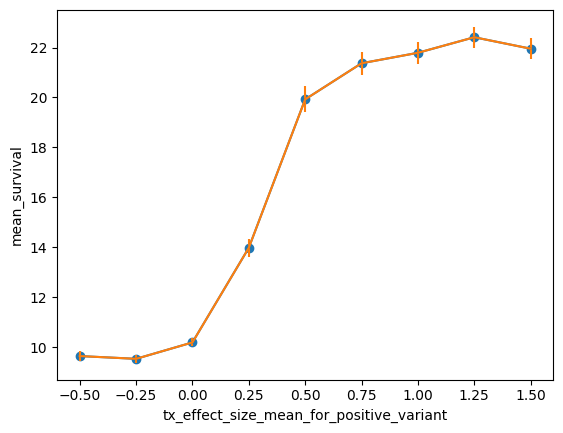

:Done

In [167]:
run(:tx_effect_size_mean_for_positive_variant,-0.5,1.5,0.25,n=200)

In [ ]:
run(:tx_effect_size_mean_for_positive_variant,-0.5,1.5,0.25,n=200)